# 笔记本2：物理仿真与机器人加载

**学习目标：**
1. 使用 `Parser` 和预设的机器人文件（URDF、SDF、MJCF）将真实机器人加载到 Drake
2. 理解 Drake 的物理仿真引擎（`MultibodyPlant`）和几何引擎（`SceneGraph`）
3. 创建自定义三维资产（你的姓名首字母！）并学习 `URDF` 和 `SDF` 的编写
4. 使用 Meshcat 可视化机器人、物体和仿真
5. 在 Drake 中构建包含自定义物体的完整机器人仿真

**你将实现的内容：** 一个完整的仿真场景，包含 IIWA14 机械臂与自定义姓名首字母资产的交互！

---


## 环境配置与导入

首先导入用于物理仿真、机器人加载和可视化的 Drake 功能。


In [6]:
from pathlib import Path

import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    BasicVector,
    Context,
    Diagram,
    DiagramBuilder,
    LeafSystem,
    MeshcatVisualizer,
    ModelInstanceIndex,
    MultibodyPlant,
    Parser,
    RigidTransform,
    Simulator,
    StartMeshcat,
)
from pydrake.visualization import ModelVisualizer

from manipulation import running_as_notebook
from manipulation.exercises.grader import Grader
from manipulation.exercises.intro.test_physics_simulation_and_robots import (
    TestPhysicsSimulationDiagramStructure,
    TestPhysicsSimulationFullSystem,
    TestPhysicsSimulationSimpleController,
    TestPhysicsSimulationVerification,
)
from manipulation.letter_generation import create_sdf_asset_from_letter
from manipulation.utils import RenderDiagram

## Meshcat 可视化

在开始之前，让我们配置 Meshcat，可视化工具。

**Meshcat** 是 Drake 的主力三维可视化工具，在你的网页浏览器中运行。它可以实时交互式地可视化机器人、物体和仿真环境。Meshcat 让你可以：

- **可视化三维机器人和场景**，带有真实几何和材质
- **实时查看仿真过程**
- **交互操作三维场景**（旋转、缩放、平移）
- **录制视频**，用于作业提交
- **调试仿真**，直观了解实际发生了什么

你会经常用 meshcat 来可视化和调试你的代码！


In [7]:
# Start meshcat for visualization
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


**点击上方链接，在浏览器中打开 Meshcat！本笔记本将一直使用同一个 Meshcat 窗口，请保持其打开！**

---

## 第一部分：加载 IIWA14 机器人

首先，让我们加载一个真实机器人！**IIWA14** 是 KUKA 公司出品的 7 自由度工业机械臂。Drake 内置了许多可直接加载的机器人模型，本部分我们就会用到。你可以在[这里](https://github.com/RobotLocomotion/models)找到所有可用的 Drake 模型列表。

**你的任务：** 使用 Drake 的物理引擎加载并可视化 IIWA14 机器人。

**核心概念：**
- `Parser`：将机器人或资产的描述文件（如 URDF/SDF/MJCF）加载到物理引擎中
- `MultibodyPlant`：Drake 的主要机器人和物体物理仿真引擎，是我们所有仿真的核心
- `SceneGraph`：Drake 用于管理几何体注册、几何查询、碰撞检测等的模块
- **基座焊接**：将机器人基座固定到世界坐标系很重要，否则它会掉下去！

**参考：** 本部分紧跟教材 [第二章](https://manipulation.csail.mit.edu/robot.html) 的 [Drake Simulation 示例](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/simulation-1ba6290623e34dbbb9d822a2180187c1) —— 重点参考 **“Simulating the (passive) iiwa”** 和 **“Visualizing the scene”** 两节。建议在开始实现前先浏览一下这些内容！

In [8]:
# TODO：加载并可视化 IIWA14 机器人
# MultibodyPlant： 用于物理仿真
# SceneGraph： 用于几何建模和可视化
# Parser： 用于加载机器人模型
# MeshcatVisualizer： 用于将 SceneGraph 可视化到 Meshcat

def create_IIWA14_diagram() -> tuple[Diagram, MultibodyPlant, ModelInstanceIndex]:
    # 提示：参见上方 Drake Simulation 示例，“Visualizing the scene”小节
    # TODO：创建 DiagramBuilder
    builder = DiagramBuilder()
    # TODO：添加 MultibodyPlant 和 SceneGraph，时间步长为 1e-4
    # 提示：有一个辅助函数可以帮你自动创建并连接这两个系统。
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)  # 将 MultibodyPlant 和 SceneGraph 实例添加到图表构建器，连接几何端口。返回场景图和物理仿真系统实例
    # 场景图用于几何建模和可视化
    # 物理仿真系统用于物理仿真

    # TODO：创建 Parser 用于加载机器人模型
    # 注意：在上方 Drake Simulation 示例中，parser 用完即丢弃，
    #       这里我们会保存 parser 以便后续添加多个模型。
    parser = Parser(plant)

    # TODO：用 parser 从 Drake 模型库加载 IIWA14 机器人模型。
    # 提示：教程中的 IIWA14 模型没有碰撞几何体，这里我们加载带有碰撞几何体的模型：
    #       "package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf"
    # 提示：parser 的 `AddModelsFromUrl` 方法返回一个模型引用列表（本例长度为 1）。
    #       需要将第一个元素保存为变量 `iiwa`。
    #       （严格来说，引用类型为 `ModelInstanceIndex`，不用担心细节。）
    iiwa = parser.AddModelsFromUrl(
        "package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf"
    )[0]

    # TODO：将机器人基座（"iiwa_link_0"）焊接到世界坐标系
    plant.WeldFrames(
        plant.world_frame(),  # 将世界坐标系
        plant.GetFrameByName("iiwa_link_0", iiwa) # 获取机器人基座的坐标系
    )

    # TODO：将 MeshcatVisualizer 添加到 builder 并连接到 SceneGraph
    meshcat_visualizer = MeshcatVisualizer.AddToBuilder(
        builder, # 将 MeshcatVisualizer 添加到图表构建器
        scene_graph, # 连接到 SceneGraph
        meshcat, # 使用之前启动的 Meshcat 实例
    )
    # TODO：finalize plant（仿真前必须）
    plant.Finalize()

    # TODO：构建完整 diagram
    diagram = builder.Build()

    # TODO：返回 diagram、plant 和 iiwa 模型实例
    return diagram, plant, iiwa


diagram, plant, iiwa = create_IIWA14_diagram()

在上面的代码中，我们加载了与教程不同的模型，因为我们需要带有碰撞几何体的模型。实际上，Drake 有许多可直接使用的模型，全部可在 [Github 仓库](https://github.com/RobotLocomotion/models) 找到，Parser 的 url 格式为 `package://drake_models/{models 仓库中的文件路径}`。

用下方代码测试你的实现：

In [9]:
Grader.grade_output([TestPhysicsSimulationDiagramStructure], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 10/10.

Score for Test IIWA14 diagram creation and structure is 10/10.


**我们还可以可视化模块图，方便你查看整体结构！**

- 注意 `MultibodyPlant`、`SceneGraph` 和 `MeshcatVisualizer` 都是模块图中的系统。
- 请务必观察各系统端口之间的连接关系！

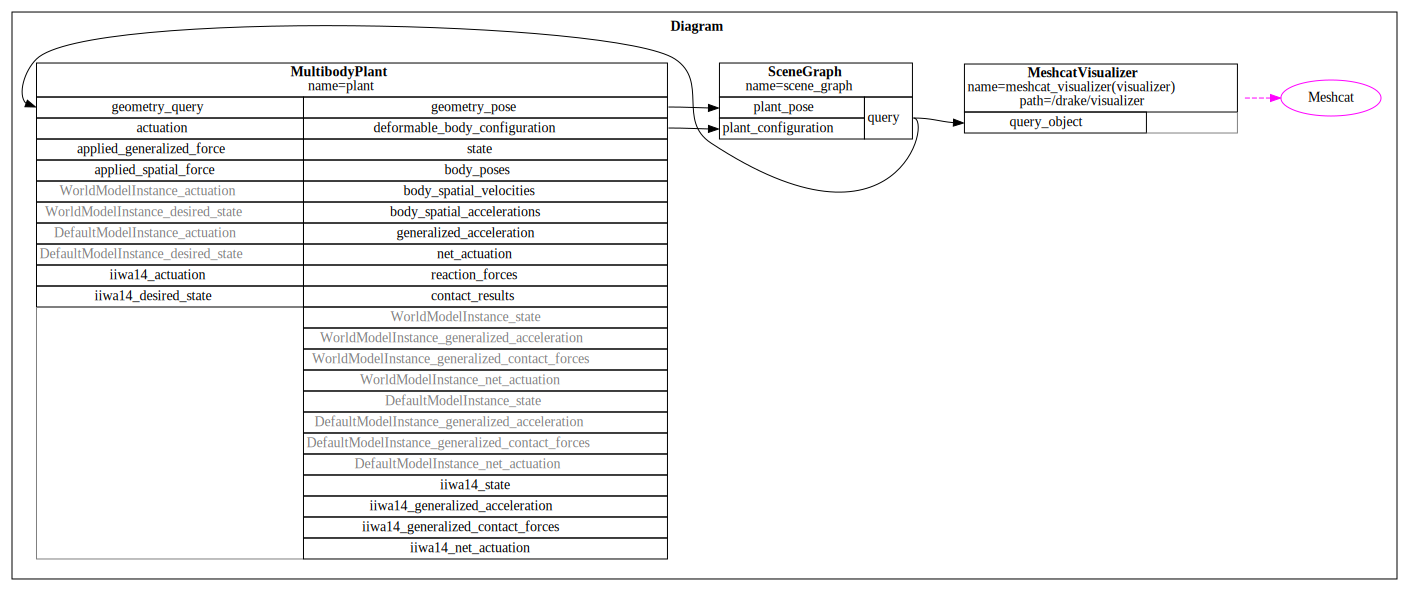

In [10]:
RenderDiagram(diagram, max_depth=1)

我们还可以为 diagram 创建一个默认 context 并打印出来，帮助我们了解当前系统状态！

**提醒：** context 保存了“全部状态”，即 diagram 内所有系统的动力学信息、仿真时间等。

In [11]:
# HINT: You already learned how to do this in the first notebook!
# TODO: Create a context for the diagram
context = diagram.CreateDefaultContext()
# TODO: Print the context
print(context)

::_ Context (of a Diagram)
---------------------------
14 total discrete states in 1 groups
1 total abstract states
273 total numeric parameters in 48 groups
16 total abstract parameters

::_::plant Context
-------------------
Time: 0
States:
  1 discrete state groups with
     14 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 abstract states

Parameters:
  48 numeric parameter groups with
     0 parameters
       
     1 parameters
       0.5
     1 parameters
       0.5
     1 parameters
       0.5
     1 parameters
       0.5
     1 parameters
       0.5
     1 parameters
       0.5
     1 parameters
       0.5
     0 parameters
       
     0 parameters
       
     0 parameters
       
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 par

哇！现在 context 里信息量很大。我们只打印 plant 的 context 看看。

（**提示：** 对于给定的 `system` 和 diagram context，可以用 `system.GetMyContextFromRoot(diagram_context)` 获取该系统的 context）

- plant 有多少个（普通）状态？和你对 IIWA14 自由度的预期一致吗？

14个状态，因为 IIWA14 有7个自由度，每个自由度有位置和速度两个状态变量。

In [12]:
# TODO: Get the context of the plant from the diagram_context
# HINT: This is important!
#       Use the method plant.GetMyContextFromRoot(diagram_context),
#       similar to what you did for the pendulum in the first notebook!
iiwa_context = plant.GetMyContextFromRoot(context)

# TODO: Print the plant context
print(iiwa_context)

::_::plant Context
-------------------
Time: 0
States:
  1 discrete state groups with
     14 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 abstract states

Parameters:
  48 numeric parameter groups with
     0 parameters
       
     1 parameters
       0.5
     1 parameters
       0.5
     1 parameters
       0.5
     1 parameters
       0.5
     1 parameters
       0.5
     1 parameters
       0.5
     1 parameters
       0.5
     0 parameters
       
     0 parameters
       
     0 parameters
       
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       100
     1 parameters
       4.54e-05
     1 parameters
       160
     1 parameters
       4.54e-05
     1 parameters
       160
     10 parameters
       nan nan nan nan n

In [13]:
positions = plant.GetPositions(iiwa_context)
print(positions)
velocities = plant.GetVelocities(iiwa_context)
print(velocities)

[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


---

## 第二部分：仅仿真 IIWA14 

很好，IIWA14 已经加载到 Drake！

现在我们设置初始条件并仿真该系统（目前只有 IIWA）。仿真时请关注 meshcat 可视化窗口！

**参考：** 本部分继续参考 [Drake Simulation 示例](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/simulation-1ba6290623e34dbbb9d822a2180187c1)。

In [14]:
# TODO：用你实现的 create_IIWA14_diagram 函数进行机器人仿真


def simulate_IIWA14(
    q0: np.ndarray, simulation_time: float = 3.0, set_target_realtime_rate: bool = True
) -> np.ndarray:
    # 提示：你在第一个笔记本已经学会了大部分内容！

    # TODO：用 create_IIWA14_diagram 创建仿真系统
    diagram, plant, iiwa = create_IIWA14_diagram()
    # TODO：创建 diagram context
    diagram_context = diagram.CreateDefaultContext()

    # 提示：参见上方 Simulation 示例，“Visualizing the scene”小节
    # TODO：用 diagram context 获取 plant 的 context
    # 提示：很重要！plant context 是 diagram context 的子集，
    #       只需修改 plant context 设置初始关节位置。
    # 提示：之前用的是 `GetMyContextFromRoot`，现在要修改 context，
    #       应用 `GetMyMutableContextFromRoot`（返回可变 context）。
    plant_context = plant.GetMyMutableContextFromRoot(diagram_context)

    # TODO：将机器人关节初始位置设置为 q0（弧度）
    plant.SetPositions(plant_context, q0)

    # TODO：将执行器输入设为零（被动仿真）
    # 提示：参见上方 Drake Simulation 示例，方法一致。
    # 提示：IIWA14 有 7 个关节，需要传入 7 个力矩值的向量
    actuation_inputs = np.zeros(7)
    plant.get_actuation_input_port(iiwa).FixValue(plant_context, actuation_inputs)
    # TODO：创建仿真器
    simulator = Simulator(diagram, diagram_context)

    # TODO：设置可视化实时速率（便于观察）
    if set_target_realtime_rate:
    # 提示：用 simulator.set_target_realtime_rate(1.0)
        simulator.set_target_realtime_rate(1.0)

    # TODO：运行仿真
    simulator.AdvanceTo(simulation_time)

    # TODO：返回最终关节位置
    # 提示：之前用 logger 记录系统输出历史，这里只需用
    #       `plant.GetPositions(plant_context)`（仿真结束后）获取最终关节位置。
    return plant.GetPositions(plant_context)

Okay! If everything is working as expected, we should now be able to simulate our system. Let us try by running the code below (if everything is working correctly, you should see the IIWA14 swinging passively in your meshcat window).


In [20]:
# Test your implementation
q_initial = np.array([0, 0, 0, 0, 0, 0, 0])

print("Starting robot simulation...")
print(f"Check your Meshcat window ({meshcat.web_url()}) to see the robot simulation!")
print("     - If the robot is not moving, the simulation already finished.")
print(
    "     - Try running this cell again (or increase the simulation time), with the meshcat window open!"
)
q_final = simulate_IIWA14(
    q_initial, simulation_time=20.0 if running_as_notebook else 0.1
)

print("Robot simulation completed!")
print(f"   Initial joint positions: {q_initial}")
print(f"   Final joint positions: {q_final}")

Starting robot simulation...
Check your Meshcat window (http://localhost:7002) to see the robot simulation!
     - If the robot is not moving, the simulation already finished.
     - Try running this cell again (or increase the simulation time), with the meshcat window open!
Robot simulation completed!
   Initial joint positions: [0 0 0 0 0 0 0]
   Final joint positions: [ 7.60710861e-02 -2.09439510e+00 -4.34915802e-02  1.19531583e+00
  6.45280827e-01 -1.56536580e-02 -1.40879528e-06]


好的，成功了。不过 IIWA 只是被动摆动。让我们写一个简单的控制器，至少能让 IIWA 基本保持在期望位置！我们会像第一个笔记本那样，把（非常简单的）控制器实现为 `LeafSystem`。注意 Drake 已经为你实现了许多高级控制器，实际项目中你通常会用那些或者写更好的控制器。这里我们只是为了学习如何将自定义 `LeafSystem` 控制器与 `MultibodyPlant` 连接，写一个非常简单（甚至有点“蠢”）的控制器。

In [ ]:
class SimpleController(LeafSystem):
    def __init__(self, gain: float, q_desired: np.ndarray) -> None:
        super().__init__()
        self.gain = gain
        self.q_desired = q_desired
        self.input_port = self.DeclareVectorInputPort("iiwa_state", 14)
        self.output_port = self.DeclareVectorOutputPort("iiwa_torque", BasicVector(7), self.ComputeTorque)

    def ComputeTorque(self, context: Context, output: BasicVector) -> None:
        state = self.input_port.Eval(context)
        q = state[:7]
        tau = -self.gain * (q - self.q_desired)
        output.SetFromVector(tau)


Run the code below to test your implementation:

In [32]:
Grader.grade_output([TestPhysicsSimulationSimpleController], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 10/10.

Score for Test SimpleController torque computation is 10/10.


In [35]:
def create_IIWA14_diagram_with_controller(
    controller_gain: float, q_desired: np.ndarray
) -> tuple[Diagram, MultibodyPlant, ModelInstanceIndex]:
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    parser = Parser(plant)
    iiwa = parser.AddModelsFromUrl(
        "package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf"
    )[0]
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("iiwa_link_0", iiwa)
    )
    plant.Finalize()

    # 创建控制器并添加到 builder
    controller = builder.AddSystem(SimpleController(controller_gain, q_desired))

    # 连接 plant 的 IIWA 状态输出端口到控制器输入端口
    builder.Connect(
        plant.get_state_output_port(iiwa),
        controller.input_port
    )

    # 连接控制器输出端口到 plant 的 IIWA 执行器输入端口
    builder.Connect(
        controller.output_port,
        plant.get_actuation_input_port(iiwa)
    )

    # 添加 Meshcat 可视化器
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    return diagram, plant, iiwa


Let us print the diagram to make sure that the connections are as expected. Make sure the the output port `iiwa14_state` from the `MultibodyPlant` system is connect to the input port of the controller, and that the output port of the controller is connected to `iiwa14_actuation` in `MultibodyPlant`!

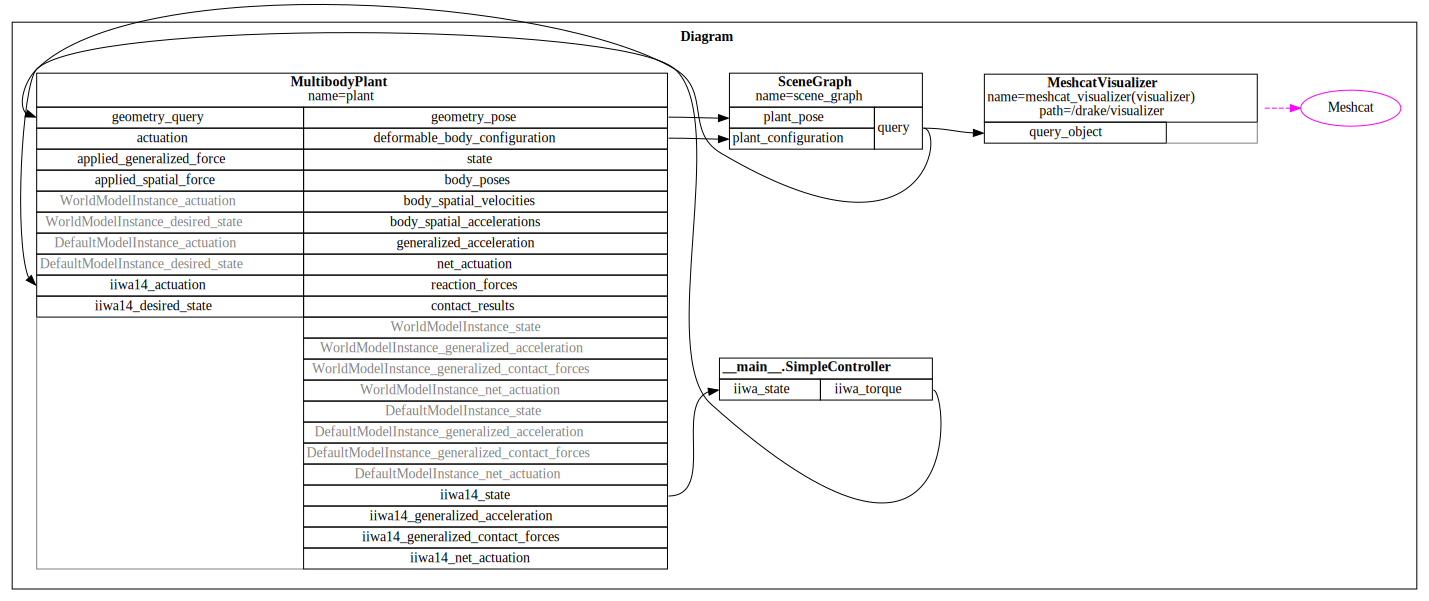

In [36]:
RenderDiagram(
    create_IIWA14_diagram_with_controller(10.0, np.array([1, 1, 0, 0, 0, 0, 0]))[0],
    max_depth=1,
)

Almost there! Now, just implement the `simulate_IIWA14` function again, but this time use your newly defined function `create_IIWA14_diagram_with_controller`:

In [47]:
# TODO：用你实现的 create_IIWA14_diagram_with_controller 函数进行机器人仿真
def simulate_IIWA14_with_controller(
    q0: np.ndarray,
    controller_gain: float,
    q_desired: np.ndarray,
    simulation_time=3.0,
    set_target_realtime_rate=True,
) -> np.ndarray:
    diagram, plant, iiwa = create_IIWA14_diagram_with_controller(controller_gain, q_desired)
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(diagram_context)
    plant.SetPositions(plant_context, iiwa, q0)
    simulator = Simulator(diagram, diagram_context)
    if set_target_realtime_rate:
        simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(simulation_time)
    return plant.GetPositions(plant_context, iiwa)

Amazing! Now let us run a simulation. How high do you have to set the gain to make the IIWA keep its starting configuration?

In [50]:
# Test your implementation
q_initial = np.array([0, 1.0, 0.3, 0.7, 0, 0, 0])

print("Starting robot simulation...")
print(f"Check your Meshcat window ({meshcat.web_url()}) to see the robot simulation!")
print("     - If the robot is not moving, the simulation already finished.")
print(
    "     - Try running this cell again (or increase the simulation time), with the meshcat window open!"
)
q_final = simulate_IIWA14_with_controller(
    q_initial,
    controller_gain=10,
    q_desired=q_initial,
    simulation_time=15 if running_as_notebook else 0.1,
    set_target_realtime_rate=running_as_notebook,
)

print("✅ Robot simulation completed!")
print(f"   Initial joint positions: {q_initial}")
print(f"   Final joint positions: {q_final}")

Starting robot simulation...
Check your Meshcat window (http://localhost:7002) to see the robot simulation!
     - If the robot is not moving, the simulation already finished.
     - Try running this cell again (or increase the simulation time), with the meshcat window open!
✅ Robot simulation completed!
   Initial joint positions: [0.  1.  0.3 0.7 0.  0.  0. ]
   Final joint positions: [ 5.81484550e-02  2.09439510e+00 -1.26308936e-01 -4.05418600e-02
  1.52214868e-01  1.48715314e-01 -6.48013717e-04]


**注意：** 你会发现这个控制器效果并不好。这是因为我们只用了一个简单的比例控制器（“P 控制器”），它只根据跟踪误差输入一个倍数。本练习的目的是教你如何使用 Drake，后续我们会学习更优秀的控制方法！

### GRADESCOPE 验证

请用以下参数仿真你的系统，并复制/粘贴 IIWA14 的最终关节位置：

- 初始位置: $[0.2, 0.2, 0.2, 0, 0, 0, 0]$
- 期望位置（q_desired）: $[0, 0, 0, 0, 0, 0, 0]$
- 控制器增益: $120.0$
- 仿真时间: $10\,\mathrm{s}$


In [51]:
# TODO：用指定初始条件和仿真时间仿真 IIWA14
q0 = np.array([0.2, 0.2, 0.2, 0, 0, 0, 0])
q_desired = np.array([0, 0, 0, 0, 0, 0, 0])
controller_gain = 120.0
simulation_time = 10.0

q_final = simulate_IIWA14_with_controller(
    q0=q0,
    controller_gain=controller_gain,
    q_desired=q_desired,
    simulation_time=simulation_time,
    set_target_realtime_rate=False,
)
print("Final joint positions:", q_final)

Final joint positions: [ 1.26317171e-02  8.13040566e-03 -5.72823579e-02 -2.43876159e-02
 -1.37802794e-04  4.71369969e-04 -2.97584254e-05]


---

## 第三部分：用 SDFormat 创建自定义模型

让我们学习如何为仿真创建自定义物体！前两部分我们用的是预定义的 SDFormat（.sdf）文件加载 IIWA14。现在我们将用同样的格式从零创建一个简单的桌子，然后用提供的 API 生成更复杂的资产（你的姓名首字母），并演示如何将它们加载到仿真中。

**你的任务：** 
1. 从零创建一个简单桌子的 SDFormat 模型
2. 用提供的 API 为你的姓名首字母生成 URDF 文件

**核心概念：**
- `SDF`、`URDF`、`MJCF`：三种常用（且非常相似）的 XML 格式，用于描述仿真中的机器人和物体
- **可视几何体**：可视化时看到的部分（可以很精细）
- **碰撞几何体**：物理引擎用于接触计算的部分（应尽量简单）
- **惯性属性**：质量和惯性，实现真实物理行为

**参考：** 本部分参考 [Authoring a Multibody Simulation Tutorial](https://github.com/RobotLocomotion/drake/blob/master/tutorials/authoring_multibody_simulation.ipynb) —— 重点关注 **“Creating custom models”** 小节，教程演示了如何用 SDFormat 字符串创建圆柱体模型。建议先浏览该节内容再开始实现！


#### 步骤1：从零编写一个简单“桌子”的 SDF 文件

SDF、URDF 和 MJCF 文件其实很简单。这里你将从零编写一个简单“桌子”的 SDF 文件，帮助你今后自定义资产。

下方代码中我们直接在代码里定义 SDF 字符串，实际项目中通常会保存为单独的 `.sdf` 文件后加载到 Drake。

**警告：** SDFormat 对缩进很敏感，请参考教程示例的缩进！也可参考 [官方 SDFormat 文档](http://sdformat.org/tutorials)


In [ ]:
# TODO：为“桌子”创建一个简单的 SDFormat 字符串（一个扁平长方体即可）。
# 提示：紧跟教程中的圆柱体示例！
# 注意：后续我们会把它当作桌子放置姓名首字母资产，
#       所以要足够大！
# 提示：推荐尺寸 2m x 2m x 0.1m
# 提示：质量可设为 1kg，惯性张量可在网上查找长方体的公式，
#       不必完全精确，只要物理合理即可。
table_sdf = """<?xml version="1.0"?>
"""

很好！如果一切顺利，我们现在应该能可视化自定义资产了。我们用 Drake 内置的 `ModelVisualizer` 可视化（见教程“Creating Custom Models”小节）。写好下方代码后，你应该能在 Meshcat 窗口看到你的桌子！

**注意：** 观看完毕后请点击 MeshCat 中“Open Controls -> Stop Running”，这样虽然可视化停止但桌子仍可见。


In [ ]:
print(f"Meshcat URL: {meshcat.web_url()}")
# HINT: Follow the authoring tutorial's example for visualizing the cylinder!
# TODO: Create a ModelVisualizer instance

# TODO: Load your table_sdf string into the visualizer

# TODO: Run the visualizer to see your box in Meshcat
# NOTE: The tutorial uses `Run(loop_once=False)`, but you can just omit the argument.

# Make sure to click "Open Controls -> Stop Running" in MeshCat when you're done viewing

#### 步骤2：用你的姓名首字母创建自定义资产

本步骤你将用姓名首字母创建自定义资产。我们已为你提供了一个库，可以为给定字母生成 `.sdf` 文件，其结构和你上面写的桌子 SDF 很类似！

下方代码已为你准备好（生成字母文件可能需要约 30 秒）。你可以自由修改字体、尺寸和挤出深度！


In [ ]:
# Let us save our files to a new folder called `assets` in the `Files`
# section on the left
output_dir = Path("assets/")

# TODO: Insert your initials here!
your_initials = "BPG"

for letter in your_initials:
    create_sdf_asset_from_letter(
        text=letter,
        font_name="DejaVu Sans",
        letter_height_meters=0.2,
        extrusion_depth_meters=0.07,
        output_dir=output_dir / f"{letter}_model",
    )

很好。继续前请在左侧“文件”区查看 `assets/` 文件夹下生成的文件，结构如下：

```
{letter}_model/
├── {letter}_parts/
│   ├── convex_piece_000.obj
│   ├── convex_piece_001.obj
│   ├── convex_piece_002.obj
│   └── ...（更多凸包网格文件）
├── {letter}.obj
└── {letter}.sdf
```

例如字母 `A`：

```
A_model/
├── A_parts/
│   ├── convex_piece_000.obj
│   ├── convex_piece_001.obj
│   ├── convex_piece_002.obj
│   └── ...（更多凸包网格文件）
├── A.obj
└── A.sdf
```

`.obj` 文件描述字母整体三维网格，`convex_piece_XXX.obj` 文件描述字母的凸包部分：这些都是文本文件，包含顶点和面列表。可以尝试用 Deepnote 的“Open in raw mode”按钮打开看看。

`.sdf` 文件描述每个字母的资产，链接整体 `.obj` 文件作为可视几何体，凸包 `.obj` 文件作为碰撞几何体（每个 mesh 必须是凸的，所以每个字母会生成多个部分！）。


很好！字母已生成。现在用 Drake 的 `ModelVisualizer` 可视化它们，检查生成效果。补全下方代码，确保每个字母都能正确显示。

**注意**：点击 `Scene > drake` 可开启惯性和碰撞几何体的可视化，这对调试资产物理属性很有帮助！

In [ ]:
print(f"Meshcat URL: {meshcat.web_url()}")

# TODO: Change this to visualize the individual letters in your initials
letter_to_visualize = "P"  # One at a time!

# This is the path to the SDF file for the letter
letter_path = f"assets/{letter_to_visualize}_model/{letter_to_visualize}.sdf"

# TODO: Define a ModelVisualizer instance
# HINT: You know how to do this by now!

# TODO: Load the letter into the visualizer using the parser
# HINT: You can just pass the path to the letter file to the parser

# TODO: Run the visualizer

---

## 第四部分：完整仿真——机器人 + 你的自定义资产

**最终大作业！** 现在我们将把所学全部结合，创建一个包含 IIWA14 机器人和你自定义姓名首字母资产的完整仿真！

**你的任务：** 构建包含以下内容的物理仿真：
1. **IIWA14 机器人**：如前焊接到世界坐标系。
2. **你的自定义桌子**：焊接到世界坐标系，靠近机器人（但不重叠！）
3. **你的姓名首字母**：放在桌子上方。

你已经掌握了全部实现所需的知识！参考前面各部分的模式完成本节。完成后请录屏（.mp4 文件，大小不超过 500 MB）并上传到 Gradescope。

**最终目标：** 用录屏工具录制仿真场景，视频应展示你的姓名首字母落到桌子上，桌子焊接在机器人附近（但不重叠）。

**提示**：`WeldFrames` 的第三个参数是 `RigidTransform`（后续课程会详细讲）。现在你可以直接用 `RigidTransform([x,y,z])` 指定偏移量。若不确定函数签名请查阅[官方文档](https://drake.mit.edu/pydrake/pydrake.multibody.plant.html)。


In [ ]:
# Before you start, make sure to run the following cell to clear the meshcat window!
meshcat.Delete()
meshcat.DeleteAddedControls()

In [60]:
# TODO：在这里实现你的完整仿真！

def simulate_full_system(
    initial_iiwa_positions: np.ndarray,
    initial_letter_poses: list[RigidTransform],
    table_pose: RigidTransform,
    simulation_time: float = 15.0,
) -> None:
    # TODO：创建 diagram builder，添加 multibody plant 和 scene graph
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    parser = Parser(plant)  
    # TODO：加载 IIWA14 机器人并焊接基座到世界坐标系
    iiwa = parser.AddModelsFromUrl(
        "package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf"
    )[0]
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("iiwa_link_0", iiwa)
    )
    # TODO：加载桌子并焊接到世界坐标系。
    #       别忘了用 `table_pose` 作为 `WeldFrames` 的第三个参数！
    table = parser.AddModelsFromString(table_sdf, "table.sdf")[0]
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("link", table),
        table_pose
    )
    # TODO：加载你的姓名首字母资产
    # 提示：用 'assets/...' 路径访问字母资产，方法同上！
    letters = []
    your_initials = "LXY"
    for letter in your_initials:
        letter_instance = parser.AddModels(f"assets/{letter}_model/{letter}.sdf")[0]
        letters.append(letter_instance) 
    # TODO：添加可视化器
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # TODO：finalize plant 并构建 diagram
    plant.Finalize()
    # TODO：创建 diagram context 和 plant context
    diagram = builder.Build()
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(diagram_context)
    # TODO：设置 IIWA14 关节初始位置。
    # 提示：现在场景中有多个自由物体，需指定
    #       设置的是 IIWA14 关节位置：
    # plant.SetPositions(plant_context, iiwa, initial_iiwa_positions)
    plant.SetPositions(plant_context, iiwa, initial_iiwa_positions)
    # TODO：加载字母并设置其初始位姿。
    # 提示：设置字母位姿需要新方法。
    #       因为字母是自由体，需要设置其位姿（位置+朝向）。
    #
    #       首先获取字母对应的 RigidBody，然后用 SetFreeBodyPose 方法设置位姿，
    #       参数为 RigidTransform。
    #
    #       例如字母 B：
    #       （注意：先加载字母，再 finalize plant，再设置位姿）
    #
    #               ```
    #               B_letter = parser.AddModels(f"assets/B_model/B.sdf")[0]
    #               ...
    #               plant.Finalize()
    #               ...
    #               body = plant.GetRigidBodyByName("B_body_link", B_letter)
    #               plant.SetFreeBodyPose(plant_context, body, initial_letter_poses[0])
    #               ```
    #
    #       （注意 SDF 中 body 名为 "B_body_link"，由字母生成函数硬编码。）
    for i, letter in enumerate(your_initials):
        letter_instance = parser.AddModelsFromFile(f"assets/{letter}_model/{letter}.sdf")[0]
        body = plant.GetRigidBodyByName(f"{letter}_body_link", letter_instance)
        plant.SetFreeBodyPose(plant_context, body, initial_letter_poses[i])
    #       按此模式为所有字母设置位姿！

    # TODO：将 plant 执行器输入固定为零
    actuation_inputs = np.zeros(7)
    plant.get_actuation_input_port(iiwa).FixValue(plant_context, actuation_inputs)
    # TODO：创建仿真器并运行 simulation_time 秒
    simulator = Simulator(diagram, diagram_context)
    simulator.set_target_realtime_rate(1.0)
    simulator.AdvanceTo(simulation_time)

Run the code below to visualize your simulation!

**Tip:** If you ever want to download a recording of your simulation as a `.html` file, append `/download` to the meshcat URL in your browser. Go ahead and try it for your simulation below!

In [61]:
print(f"Meshcat URL: {meshcat.web_url()}")

# Notice that we have wrapped your function in a `meshcat.StartRecording()` and `meshcat.StopRecording()` block,
# followed by a `meshcat.PublishRecording()` call. This is a convenient way to make it possible to replay the
# simulation in meshcat after the simulation ends!
meshcat.StartRecording()
simulate_full_system(
    initial_iiwa_positions=np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0]),
    initial_letter_poses=[
        # You can add rotations to the RigidTransform if you want, but we will learn more about that later!
        # The letters should be placed such that they are not in collision with each other, and such that
        # they fall onto the table.
        RigidTransform([0.7, 0.0, 1.0]),
        RigidTransform([0.9, 0.0, 1.0]),
        RigidTransform([1.1, 0.0, 1.0]),
    ],
    table_pose=RigidTransform(
        [0.5, 0.0, -0.05]
    ),  # this is a reasonable position for a 2m x 2m x 0.05m table, but feel free to change it!
    simulation_time=5.0 if running_as_notebook else 0.1,
)
meshcat.StopRecording()
meshcat.PublishRecording()

[0.0667       0       0]
[     0  0.0667       0]
[     0       0  0.2667]
did not pass the test CouldBePhysicallyValid().
The associated principal moments of inertia:
0.0667  0.0667  0.2667
do not satisfy the triangle inequality.


Meshcat URL: http://localhost:7002


RuntimeError: error: Error finding file [/mnt/c/Users/lvxiangyu11/code/drake/robotic_manipulation/0_introduction/assets/L_model/L.sdf].

# GRADESCOPE 验证
恭喜你！本笔记本全部完成。现在在浏览器中回放仿真并将录屏（mp4，500MB 以下）上传到 Gradescope。

---

# 恭喜你！

你已成功完成 **笔记本2：物理仿真与机器人加载**！

### 总结

本笔记本你学会了：

- 用 Meshcat 可视化机器人、物体和仿真
- 用 `Parser` 和机器人描述文件加载真实机器人（本次只用 SDF，URDF 和 MJCF 也很类似！）
- 理解 Drake 的物理仿真引擎（`MultibodyPlant`）和几何引擎（`SceneGraph`）
- 创建自定义三维资产，学习 URDF/SDF 编写
- 在 Drake 中构建包含自定义物体的完整机器人仿真

你已掌握 Drake 物理仿真和自定义机器人环境的基础技能。这些能力对后续进阶内容和课程项目都至关重要！

**下一步：** 在笔记本3中，你将学习如何用 `scenario.yaml` 文件和 `HardwareStation` 快速搭建复杂场景。